In [1]:
import pandas as pd 
import numpy as np
from numpy import array
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
from ipynb.fs.full.evaluation import *
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from ipynb.fs.full.Data_Processing import *
from sklearn import preprocessing
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
torch.set_printoptions(linewidth=120) #Display options for output
torch.set_grad_enabled(True) # Already on by default
torch.manual_seed(0)
from torch_lr_finder import LRFinder
import pickle
import torch.utils.data as data_utils
from collections import namedtuple
import time
from sklearn.model_selection import KFold
from pytorchtools import EarlyStopping

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True




### CNN

In [3]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(EEGNet, self).__init__()
        self.T = 120
        self.combined = combined
        self.fc_size = fc_size
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 8), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(fc_size, num_classes)
        
    def forward(self, x):
        # Layer 1
        x = x.float()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.9)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.9)
        x = self.pooling2(x)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.9)
        x = self.pooling3(x)
 
        # FC Layer
        x = x.view(-1, self.fc_size)
        if self.combined == False:       
            x = self.fc1(x)
        return x
    

    
    # for 60 timepoints = 4*2*4 and -1
    # 120 timepoints = 4* 2* 7 and -1
    # https://discuss.pytorch.org/t/runtimeerror-shape-1-400-is-invalid-for-input-of-size/33354
    # https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498/2

### CNN + RNN

https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

In [4]:
   

class Combine(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(Combine, self).__init__()
        self.cnn = EEGNet(num_classes,combined, fc_size)
        self.rnn = nn.LSTM(
            input_size=fc_size, 
            hidden_size=16, 
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(16 ,num_classes)

    def forward(self, x):
        batch_size, C, timepoints, channels = x.size()
        c_in = x
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, -1 , c_out.shape[1])
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)
    

**Evaluate function returns values of different criteria like accuracy, precision etc.**
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [5]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted , multi_class="ovr"))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted), average='macro'))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted) , average='macro'))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted) , average='macro')
            recall = recall_score(Y, np.round(predicted) , average='macro')
            results.append(2*precision*recall/ (precision+recall))
    return results

**Generate random data**
    
*Data format:*

Datatype - float32 (both X and Y)

X.shape - (#samples, 1, #timepoints, #channels)

Y.shape - (#samples)

In [6]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()### Scale the data

In [7]:
def learning_rate_finder():
    model = EEGNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
    lr_finder.plot()

In [8]:
def get_accuracy(loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return acc

In [162]:
def predict(loader, net):
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return np.concatenate(predictions)

In [163]:
def train(X_train, train_loader, valid_loader,  num_classes, model, n_epochs, patience, train_verbose, fc_size):
    
    # choose between the EEGNet or EEGNet + RNN
    if model == 'EEGNet':
        net = EEGNet(num_classes, False, fc_size).to(device)
    else: 
        net = Combine(num_classes, True, fc_size).to(device)
        
    #store the predictions and the losses
    preds_list = [] # track the predictions
    labels_list = [] # track the labels
    train_losses = [] # to track the train loss as the model trains
    valid_losses = [] # to track the validation loss as the model trains
    avg_train_losses = [] # to track the average training loss per epoch as the model trains
    avg_valid_losses = [] # to track the average validation loss per epoch as the model trains
    
    #Set the optimiser 
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    #Initialise the early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=train_verbose)

    for epoch in range(n_epochs):
        total_loss = 0
        total_correct = 0

        net.train() # prep the model for training
        for batch in train_loader:

            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            preds = net(inputs) #forward pass: compute predicted outputs by passing inputs to the model
            criterion=nn.BCEWithLogitsLoss() # calculate the loss
            loss = F.cross_entropy(preds, labels.long()) # calculate loss
            optimizer.zero_grad()# clear the gradients of all optimized variables
            loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_losses.append(loss.item()) # record training loss
            
            #record the predictions and losses
            preds_list.append(preds)
            labels_list.append(labels)
            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)
            
        ######################    
        # validate the model #
        ######################
        net.eval() # prep model for evaluation
        for batch in valid_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            preds = net(inputs)
            # calculate the loss
            loss = F.cross_entropy(preds, labels.long())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '+
                     f'train_accuracy: {total_correct/len(X_train):.5f}' )
        
        if train_verbose == True: print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break       
        
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))
    
    return net, avg_train_losses, avg_valid_losses

### Training and testing

In [164]:
def standardise(X_train, X_valid):
    # standardize per channel
    means = X_train.mean(axis=(0,2), keepdims=True)
    stds = X_train.std(axis=(0,2), keepdims=True)
    X_train = (X_train - means) / (stds)
    X_valid = (X_valid - means) / (stds)
    return X_train, X_valid


In [165]:
def average(lst): 
    return sum(lst) / len(lst)

In [166]:
def is_slice_in_list(s,l):
    """
    Function for checking whether a slice is in a list. Mainly used for checking whether the 
    """
    len_s = len(s) #so we don't recompute length of s on every iteration
    return any(s == l[i:len_s+i] for i in range(len(l) - len_s+1))

In [167]:
def categorise(y_train, y_valid):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_valid = le.transform(y_valid)
    return y_train, y_valid, le

In [168]:
def save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass ):
    if model_type == 'clf':
        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/clf/confusion/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}.png".format(user,label,n_epochs,model, eval_type, bandpass)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)
        
        #plot model
    if model_type == 'reg':
        saved_file = "results/CNN/reg/y vs y_pred/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}.png".format(user,label, n_epochs,model,eval_type, bandpass)
        plot_model(y_true, y_pred, user, label,file=saved_file)
    
    saved_file = "results/CNN/clf/loss curves/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}.png".format(user,label,n_epochs,model, eval_type, bandpass)
    plot_loss_early_stop(train_loss, valid_loss, saved_file)

In [169]:
def get_loaders(X_train, X_valid, y_train, y_valid):
    
    #Convert to 4D 
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],X_train.shape[2])
    X_valid = X_valid.reshape(X_valid.shape[0],1, X_valid.shape[1],X_valid.shape[2])

    # Create train and valid loader
    train = data_utils.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
    valid = data_utils.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
    train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)
    valid_loader = data_utils.DataLoader(valid, batch_size=50, shuffle=False)       
    return train_loader, valid_loader

In [ ]:
def multiply(data, multiple):
    """
    Method for multiplying a dataset
    :data: chosen dataset
    :multiply: chosen number to multiply the dataset
    """
    data_list = []
    for i in range (multiple):
        data_list.append(data)
    data = np.concatenate(data_list)
    return data


# Gaussian noise

# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.normal.html

bandpass = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_True_slider_120.pickle")
clean_signal = bandpass[1]['inputs']

def add_gaussian_noise(clean_signal, multiple, sigma):
    """
    Method for multiplying a given dataset and adding gausian noise
    :clean_signal: clean dataset without noise
    :multiple: chosen number to multiply the dataset
    :sigma: standard deviation
    """
    print("Starting size: {0}".format(clean_signal.shape))
    #multiply the dataset
    clean_signal = multiply(clean_signal, multiple)

    # add noise to the dataset based on the shape of the multiplied dataset
    mu = 0 # average needs to be zero to generate gaussian noise
    noise = np.random.normal(mu, sigma, clean_signal.shape)
    noisy_signal = clean_signal + noise
    print("End size: {0}".format(noisy_signal.shape))
    return noisy_signal


def multiply(data, multiple):
    """
    Method for multiplying a dataset
    :data: chosen dataset
    :multiply: chosen number to multiply the dataset
    """
    data_list = []
    for i in range (multiple):
        data_list.append(data)
    data = np.concatenate(data_list)
    return data


# Gaussian noise

# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.normal.html

bandpass = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_True_slider_120.pickle")
clean_signal = bandpass[1]['inputs']

def add_gaussian_noise(clean_signal, multiple, sigma):
    """
    Method for multiplying a given dataset and adding gausian noise
    :clean_signal: clean dataset without noise
    :multiple: chosen number to multiply the dataset
    :sigma: standard deviation
    """
    print("Starting size: {0}".format(clean_signal.shape))
    #multiply the dataset
    clean_signal = multiply(clean_signal, multiple)

    # add noise to the dataset based on the shape of the multiplied dataset
    mu = 0 # average needs to be zero to generate gaussian noise
    noise = np.random.normal(mu, sigma, clean_signal.shape)
    noisy_signal = clean_signal + noise
    print("End size: {0}".format(noisy_signal.shape))
    return noisy_signal




In [170]:
def kfold_predict(X,y, model_type, model, n_epochs, train_verbose, patience, fc_size):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    
    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}
        
    total_predictions = []
    total_true = []
    num_classes = 0
    accuracy = []
    fold = 0
    for train_index, test_index in kf.split(X):
        
        #Train/valid split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        size = len(X_train) + len(X_valid)
        
        # check the the classes in the validation set, if there are not in training set then skip
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))
        if is_slice_in_list(y_valid_classes, y_train_classes) == False: continue
        
        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #label the categorical variables
        y_train, y_valid, le = categorise(y_train, y_valid)
        
        # augment data
        
        
        #get loaders
        train_loader, valid_loader = get_loaders(X_train, X_valid, y_train, y_valid)
        
         # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))
       
        # train the network
        time_start = time.time()
        net, train_loss, valid_loss = train(X_train, train_loader, valid_loader, 
                    num_classes, model, n_epochs, patience, train_verbose, fc_size)
        fold += 1 
        print('Fold  {0}! Time elapsed: {1} seconds'.format(fold, time.time()-time_start))
        
        # make predictions
        y_pred = le.inverse_transform(predict(valid_loader, net))
        y_true = le.inverse_transform(y_valid)
     
        #save total predictions and get results
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type) #returns a dictionary of results   
        valid_acc = get_accuracy(valid_loader, net)
        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        accuracy.append(valid_acc)

    for key in results: # average out the results 
        results[key] = average(results[key])
    accuracy = average(accuracy)
    total_predictions = np.concatenate(total_predictions)
    total_true = np.concatenate(total_true)
        
        
    return results, total_predictions , total_true , num_classes , size , accuracy, train_loss, valid_loss




#get results
#         Results = namedtuple("Results","label train_acc test_acc user")
#         train_acc = get_accuracy(train_loader, test_loader, "train", net)
#         test_acc = get_accuracy(train_loader, test_loader, "test", net)
#         print("{0} results on User 1\ntrain_acc: {1}\tsample_size: {2}\ntest_acc: {3}\tsample_size: {4}\n".format(label, 
#                                                                                                train_acc,  len(X_train),
#                                                                                                 test_acc, len(X_test)))
#         results.append(Results(label, train_acc, test_acc,1))

In [171]:

# bandpass = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_True_slider_120.pickle")
# no_p = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass_False_slider_120.pickle")

# bandpass_lgbm = load_file("/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_120_window_annotated_EEG_agg_bandpass.pickle")
# bandpass[1]['inputs']

Working on label attention
epoch: [   0/1000] train_loss: 2.30361 valid_loss: 1.57189 train_accuracy: 0.23263
Validation loss decreased (inf --> 1.571887).  Saving model ...
epoch: [   1/1000] train_loss: 1.56120 valid_loss: 1.54473 train_accuracy: 0.25508
Validation loss decreased (1.571887 --> 1.544726).  Saving model ...
epoch: [   2/1000] train_loss: 1.53800 valid_loss: 1.54476 train_accuracy: 0.26142
EarlyStopping counter: 1 out of 10
epoch: [   3/1000] train_loss: 1.52312 valid_loss: 1.57264 train_accuracy: 0.28140
EarlyStopping counter: 2 out of 10
epoch: [   4/1000] train_loss: 1.50616 valid_loss: 1.58894 train_accuracy: 0.29804
EarlyStopping counter: 3 out of 10
epoch: [   5/1000] train_loss: 1.49161 valid_loss: 1.66286 train_accuracy: 0.30966
EarlyStopping counter: 4 out of 10
epoch: [   6/1000] train_loss: 1.48158 valid_loss: 1.70714 train_accuracy: 0.31213
EarlyStopping counter: 5 out of 10
epoch: [   7/1000] train_loss: 1.46212 valid_loss: 1.78499 train_accuracy: 0.32229
E

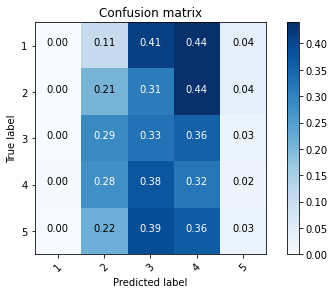

<Figure size 432x288 with 0 Axes>

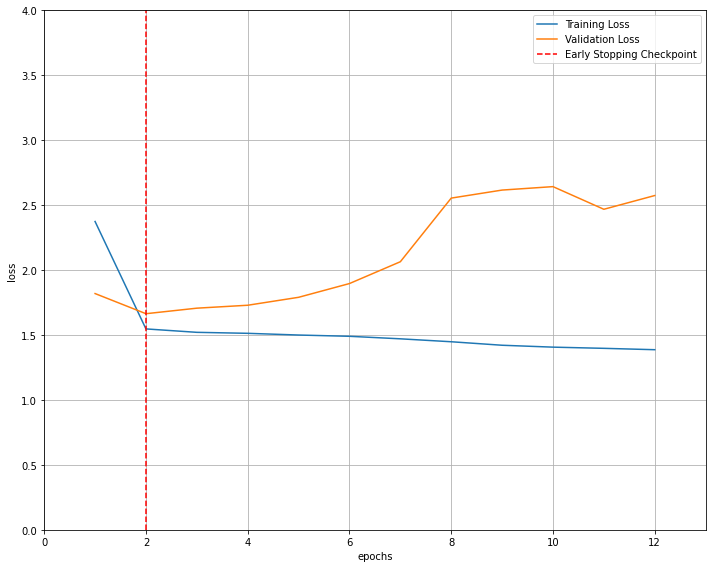

Finished analysis on label attention. Time elapsed 111.65090823173523
Finished analysis on User all
All analyses are complete! Time elapsed: 111.719158411026
Working on label attention
epoch: [   0/1000] train_loss: 1.57874 valid_loss: 1.54582 train_accuracy: 0.24780
Validation loss decreased (inf --> 1.545823).  Saving model ...
epoch: [   1/1000] train_loss: 1.55475 valid_loss: 1.53891 train_accuracy: 0.26042
Validation loss decreased (1.545823 --> 1.538910).  Saving model ...
epoch: [   2/1000] train_loss: 1.52705 valid_loss: 1.61346 train_accuracy: 0.28073
EarlyStopping counter: 1 out of 10
epoch: [   3/1000] train_loss: 1.46420 valid_loss: 1.83165 train_accuracy: 0.31668
EarlyStopping counter: 2 out of 10
epoch: [   4/1000] train_loss: 1.42559 valid_loss: 1.87666 train_accuracy: 0.34246
EarlyStopping counter: 3 out of 10
epoch: [   5/1000] train_loss: 1.41378 valid_loss: 1.89918 train_accuracy: 0.34627
EarlyStopping counter: 4 out of 10
epoch: [   6/1000] train_loss: 1.40822 valid

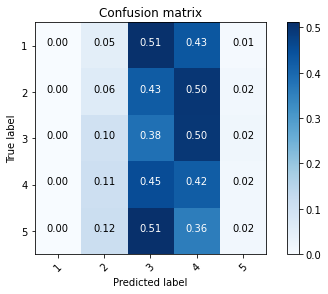

<Figure size 432x288 with 0 Axes>

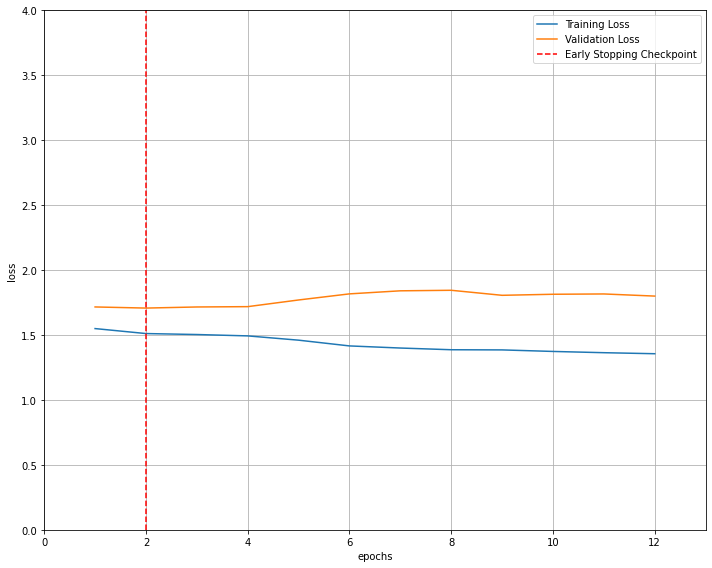

Finished analysis on label attention. Time elapsed 121.70338249206543
Finished analysis on User all
All analyses are complete! Time elapsed: 121.76541328430176


In [173]:
def run_per_user(model , train_verbose, window_size_samples, fc_size, bandpass):

    time_original = time.time()

    labels = ["attention", "interest", "effort"]

    n_epochs = 100

    patience = 10
    window_size_samples = 120
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests = load_file(saved_file)
    users = list(all_tests.keys())
    model_type = 'clf'
    results = []
    eval_type = 'per user'
    
    for user in users:
        print("Working on user {0}".format(user))

        for label in labels:

            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).astype(np.float32) for x in dt['inputs']]) # array of all the inputs for each test
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # K fold predict 
            r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y, model_type, 
                                                                                                   model, n_epochs, 
                                                                                                    train_verbose, patience, fc_size)
   
            # get results and add them to the list
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples, model))

            #Save plots
            save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss)

            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}.csv".format(window_size_samples, n_epochs, model, model_type, eval_type), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results
        
    
def run_cross_user(model , train_verbose, window_size_samples, fc_size, bandpass):
    time_original = time.time()

    labels = ["attention", 'interest', 'effort']
    results = [] # save all results in this list
    patience = 10
    n_epochs = 100
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    model_type = 'clf'
    user ='all'
    eval_type = 'cross user'
   

    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()

        # Store each user in a list to prepare for cross-user analysis
        X = np.array([all_tests_agg[user]['inputs'].astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y,model_type, model,
                                                                                               n_epochs, train_verbose, patience, fc_size)

         # get results
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, duration, num_classes, size, model_type, n_epochs, window_size_samples,model))
        
        #Save plots
        save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass)
                 
        print("Finished analysis on label {0}. Time elapsed {1}".format(label, time.time()-time_start))
    print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results).to_csv("results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}_dropout_0.9_attention_bandpass_{5}.csv".format(window_size_samples, n_epochs, model,
                                                                                                                                                                            model_type, eval_type, bandpass), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))


# windows = [15, 30, 60, 120, 250]
# fc_sizes = [8, 16, 32, 56, 120]
# for window, fc_size in zip(windows, fc_sizes):

window = 120
fc_size = 56
bandpass = True


run_cross_user('EEGNet', True, window, fc_size,bandpass) 
# run_cross_user('Hybrid', True, window, fc_size, bandpass)       
        